In [75]:
%matplotlib notebook

# Nuclei Image Segmentation Tutorial

In this tutorial, we will implement a UNet to solve Kaggle's [2018 Data Science Bowl Competition](https://www.kaggle.com/c/data-science-bowl-2018). The challenge asks participants to find the location of nuclei from images of cells. The source of this tutorial and instructions to reproduce this analysis can be found at the [thomasjpfan/ml-journal repo](https://github.com/thomasjpfan/ml-journal/tree/master/notebooks/nuclei-cell-image-segmentation).

In [76]:
# <!-- collapse=None -->
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import SGD
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits
from sklearn.model_selection import train_test_split


from dataset import CellsDataset, PatchedDataset
from model import UNet
from utils import plot_cells, plot_masks, freeze_layer, plot_mask_cells

torch.manual_seed(0);

## Exploring the Data

We can now define the datasets training and validiation datasets:

In [77]:
samples_dirs = list(d for d in Path('data/cells/').iterdir() if d.is_dir())
my_samples_dirs_1 = list(d for d in Path('my_data_originals_0522-2025-day4-ref1-tile/my_data/cells/').iterdir() if d.is_dir())
#my_samples_dirs_2 = list(d for d in Path('my_data_256_factor2_black-padding_original/cells/').iterdir() if d.is_dir())
#my_samples_dirs_3 = list(d for d in Path('my_data_256_factor2_reflect-padding_original/cells/').iterdir() if d.is_dir())



train_dirs, valid_dirs = train_test_split(
    samples_dirs, test_size=0.1, random_state=42)

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)
my_cell_ds_1 = CellsDataset(my_samples_dirs_1)
#my_cell_ds_2 = CellsDataset(my_samples_dirs_2)
#my_cell_ds_3 = CellsDataset(my_samples_dirs_3)

In [78]:
len(valid_cell_ds)

55

Overall the cell images come in different sizes, and fall in three different categories:

In [5]:
"""# <!-- collapse=None -->
type1_id, type2_id, type3_id = 1, 2, 3
plot_cells(valid_cell_ds[type1_id][0],
           valid_cell_ds[type2_id][0],
           valid_cell_ds[type3_id][0].crop((200, 200, 500, 500)))
"""

'# <!-- collapse=None -->\ntype1_id, type2_id, type3_id = 1, 2, 3\nplot_cells(valid_cell_ds[type1_id][0],\n           valid_cell_ds[type2_id][0],\n           valid_cell_ds[type3_id][0].crop((200, 200, 500, 500)))\n'

In [6]:
"""type1_id, type2_id, type3_id = 1, 2, 3
print(my_samples_dirs)
print(my_cell_ds[type1_id][0])
plot_cells(my_cell_ds[type1_id][0],
           my_cell_ds[type2_id][0],
           my_cell_ds[type3_id][0])
"""

'type1_id, type2_id, type3_id = 1, 2, 3\nprint(my_samples_dirs)\nprint(my_cell_ds[type1_id][0])\nplot_cells(my_cell_ds[type1_id][0],\n           my_cell_ds[type2_id][0],\n           my_cell_ds[type3_id][0])\n'

Most of the data is of Type 2. Training a single model to be able to find the nuclei for all types may not be the best option, but we will give it a try! For reference here are the corresponding masks for the above three types:

In [7]:
"""# <!-- collapse=None -->
plot_masks(valid_cell_ds[type1_id][1],
           valid_cell_ds[type2_id][1],
           valid_cell_ds[type3_id][1])
           """

'# <!-- collapse=None -->\nplot_masks(valid_cell_ds[type1_id][1],\n           valid_cell_ds[type2_id][1],\n           valid_cell_ds[type3_id][1])\n           '

In order to train a neutral net, each image we feed in must be the same size. For our dataset, we break our images up into 256x256 patches. The UNet architecture typically has a hard time dealing with objects on the edge of an image. In order to deal with this issue, we pad our images by 16 using reflection. The image augmentation is handled by `PatchedDataset`. Its implementation can be found in `dataset.py`.

In [79]:
train_ds = PatchedDataset(
    train_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)
val_ds = PatchedDataset(
    valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=False)

my_ds_1 = PatchedDataset(
    my_cell_ds_1[0], patch_size=(256, 256), padding=16, random_flips=False)
"""
my_ds_2 = PatchedDataset(
    my_cell_ds_2[0], patch_size=(256, 256), padding=16, random_flips=False)

my_ds_3 = PatchedDataset(
    my_cell_ds_3[0], patch_size=(256, 256), padding=16, random_flips=False)

#print(my_ds)
#print(my_samples_dirs[3].name)
"""

'\nmy_ds_2 = PatchedDataset(\n    my_cell_ds_2[0], patch_size=(256, 256), padding=16, random_flips=False)\n\nmy_ds_3 = PatchedDataset(\n    my_cell_ds_3[0], patch_size=(256, 256), padding=16, random_flips=False)\n\n#print(my_ds)\n#print(my_samples_dirs[3].name)\n'

## Defining the Module

Now we define the UNet module with the pretrained `VGG16_bn` as a feature encoder. The details of this module can be found in `model.py`:

In [80]:
module = UNet(pretrained=True)

## Freezer

The features generated by `VGG16_bn` are prefixed with `conv`. These weights will be frozen, which restricts training to only our decoder layers. 

In [81]:
from skorch.callbacks import Freezer
freezer = Freezer('conv*')

## Learning Rate Scheduler

We use a Cyclic Learning Rate scheduler to train our neutral network.

In [11]:
"""
from skorch.callbacks import LRScheduler
from skorch.callbacks.lr_scheduler import CyclicLR

cyclicLR = LRScheduler(policy=CyclicLR, 
                       base_lr=0.002, 
                       max_lr=1,
                       step_size_up=540,
                       step_size_down=540)
"""

'\nfrom skorch.callbacks import LRScheduler\nfrom skorch.callbacks.lr_scheduler import CyclicLR\n\ncyclicLR = LRScheduler(policy=CyclicLR, \n                       base_lr=0.002, \n                       max_lr=1,\n                       step_size_up=540,\n                       step_size_down=540)\n'

In [12]:
""""
from skorch.callbacks import LRScheduler
from skorch.callbacks.lr_scheduler import CyclicLR

cyclicLR = LRScheduler(policy=CyclicLR, 
                       base_lr=0.002, 
                       max_lr=0.6,
                       step_size_up=540,
                       step_size_down=540)
"""

'"\nfrom skorch.callbacks import LRScheduler\nfrom skorch.callbacks.lr_scheduler import CyclicLR\n\ncyclicLR = LRScheduler(policy=CyclicLR, \n                       base_lr=0.002, \n                       max_lr=0.6,\n                       step_size_up=540,\n                       step_size_down=540)\n'

In [13]:
"""from skorch.callbacks import LRScheduler
from skorch.callbacks.lr_scheduler import CyclicLR

cyclicLR = LRScheduler(policy=CyclicLR, 
                       base_lr=0.002, 
                       max_lr=0.4,#1#0.4#0.2#0.1#0.04#0.02#0.01
                       step_size_up=1,
                       step_size_down=1079)
"""

In [82]:

from skorch.callbacks import LRScheduler
from skorch.callbacks.lr_scheduler import WarmRestartLR

cyclicLR = LRScheduler(policy=WarmRestartLR, 
                       min_lr=0.002, 
                       max_lr=0.4,
                       base_period=1080,
                       period_mult=1,
                       last_epoch=-1
                       )

#WarmRestartLR(optimizer, min_lr=1e-06, max_lr=0.05, base_period=10, period_mult=2, last_epoch=-1)


In [15]:
#LRScheduler

**Why is step_size_up 540?**

Since we are using a batch size of 32, each epoch will have about 54 (`len(train_ds)//32`) training iterations. We are also setting `max_epochs` to 20, which gives a total of 1080 (`max_epochs*54`) training iterations. We construct our Cyclic Learning Rate policy to peak at the 10th epoch by setting `step_size_up` to 540. This can be shown with a plot of the learning rate:

<IPython.core.display.Javascript object>


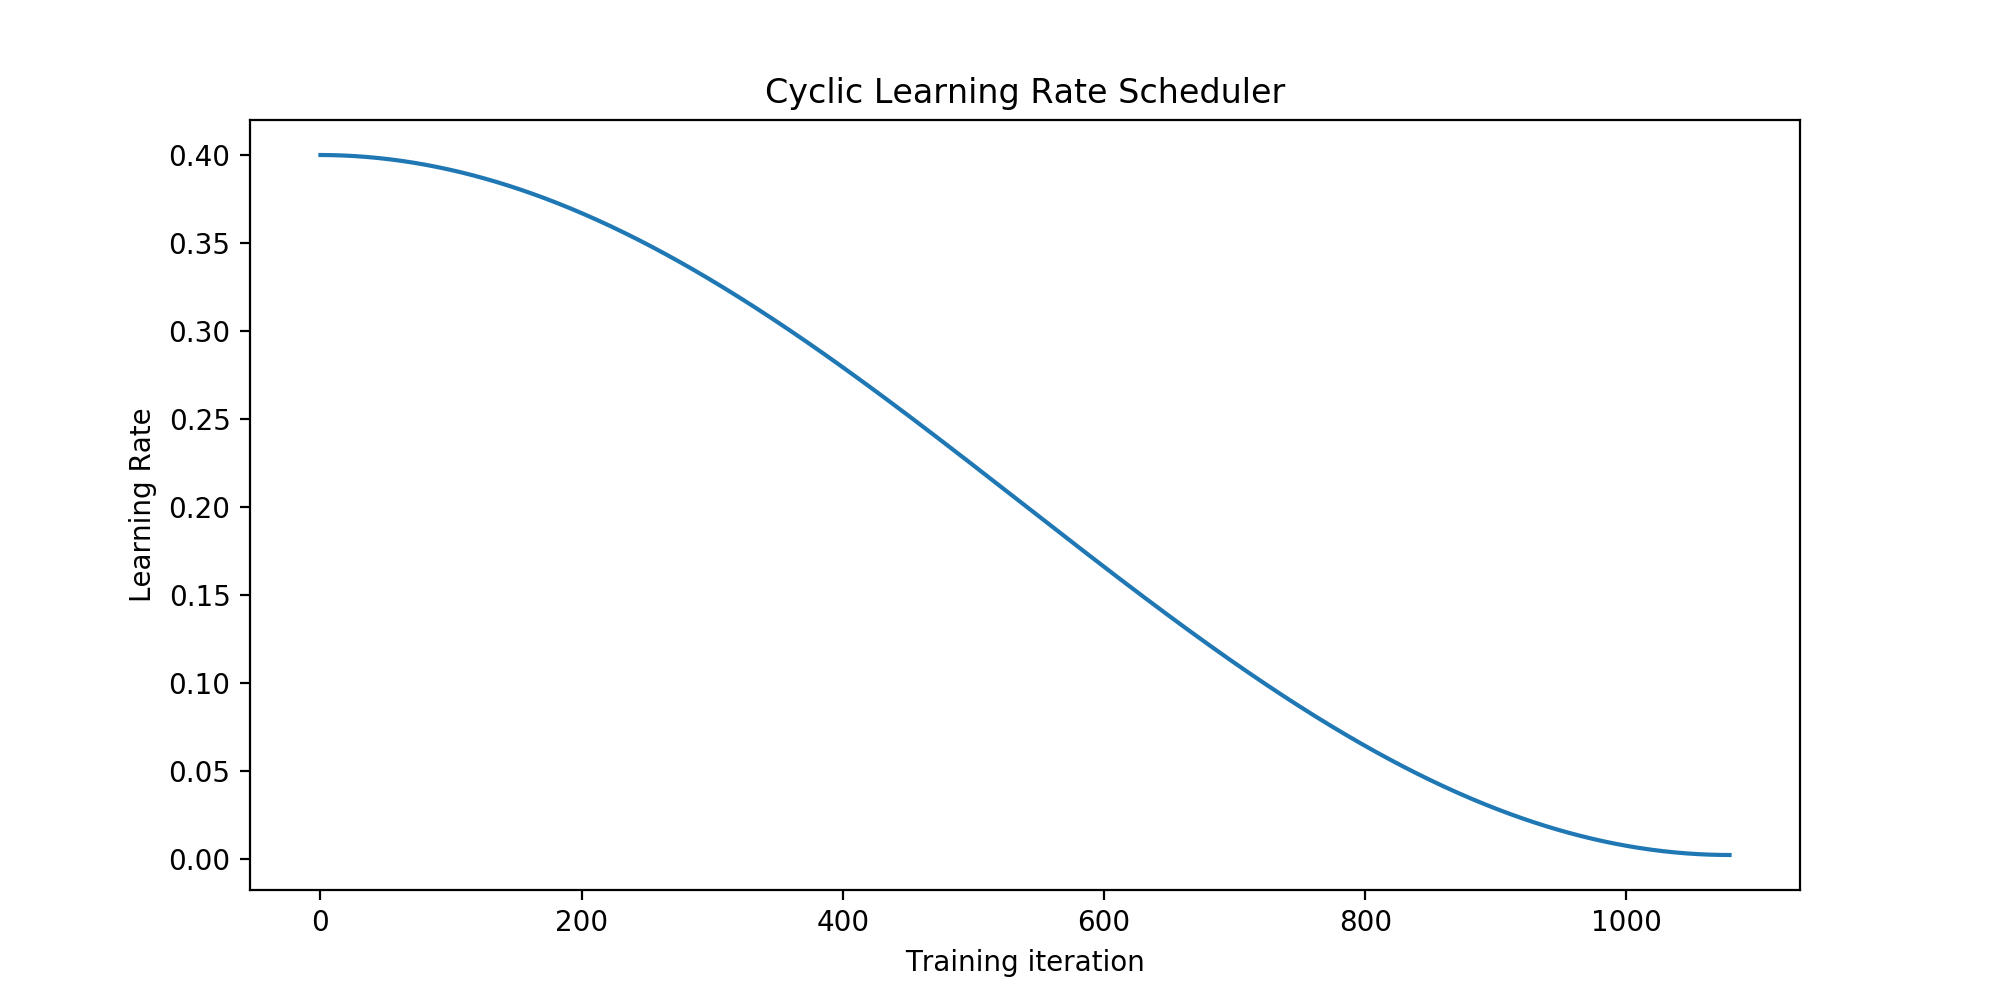

In [83]:
_, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Cyclic Learning Rate Scheduler')
ax.set_xlabel('Training iteration')
ax.set_ylabel('Learning Rate')
ax.plot(cyclicLR.simulate(1080, 0.002));

## Checkpoint

A checkpoint is used to save the model weights with the best loss:

In [84]:
from skorch.callbacks import Checkpoint

checkpoint = Checkpoint(dirname='unet')

## Custom Loss Module

Since we have padded our images and mask, the loss function will need to ignore the padding when calculating the binary log loss. We define a `BCEWithLogitsLossPadding` to filter out the padding:

In [85]:

class BCEWithLogitsLossPadding(nn.Module):
    def __init__(self, padding=16):
        super().__init__()
        self.padding = padding

    def forward(self, input, target):
        input = input.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        target = target.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        return binary_cross_entropy_with_logits(input, target)
        


In [19]:
"""
from torch.nn.functional import mse_loss

class MSE_loss(nn.Module):
    def __init__(self, padding=16):
        super().__init__()
        self.padding = padding

    def forward(self, input, target):
        input = input.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        target = target.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        return mse_loss(input, target)     
"""

'\nfrom torch.nn.functional import mse_loss\n\nclass MSE_loss(nn.Module):\n    def __init__(self, padding=16):\n        super().__init__()\n        self.padding = padding\n\n    def forward(self, input, target):\n        input = input.squeeze_(\n            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]\n        target = target.squeeze_(\n            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]\n        return mse_loss(input, target)     \n'

## Training Skorch NeutralNet

Now we can define the `skorch` NeutralNet to train out UNet!

In [86]:
from skorch.net import NeuralNet
from skorch.helper import predefined_split

net = NeuralNet(
    module,
    criterion=BCEWithLogitsLossPadding,#MSE_loss,
    criterion__padding=16,
    batch_size=32,
    max_epochs=500,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    train_split=predefined_split(val_ds),#None,#predefined_split(val_ds),
    callbacks=[('freezer', freezer),
               ('cycleLR', cyclicLR), 
               ('checkpoint', checkpoint)],
    device='cuda' 
)

In [13]:
"""
from sklearn.pipeline import Pipeline 
model = Pipeline([
    
    ('net', net)
])

"""

Let's highlight some parametesr in our `NeutralNet`:

1. `criterion__padding=16` - Passes the padding to our `BCEWithLogitsLossPadding` initializer. 
2. `train_split=predefined_split(val_ds)` - Sets the `val_ds` to be the validation set during training.
3. `callbacks=[(..., Checkpoint(f_params='best_params.pt'))]` - Saves the best parameters to `best_params.pt`.

Next we train our UNet with the training dataset:

In [16]:
#model.fit(train_ds);

  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.2249        0.2027     +  64.0403
      2        0.1205        0.0891     +  52.4752
      3        0.0718        0.0636     +  52.7892
      4        0.0531        0.0473     +  52.7809
      5        0.0509        0.0457     +  52.7014
      6        0.0488        0.0444     +  52.8022
      7        0.0490        0.0428     +  52.6382
      8        0.0464        0.0445        52.8213
      9        0.0458        0.0436        52.7537
     10        0.0456        0.0416     +  52.7438
     11        0.0457        0.0439        52.6149
     12        0.0448        0.0463        52.8985
     13        0.0442        0.0408     +  52.7846
     14        0.0441        0.0397     +  52.7026
     15        0.0438        0.0430        52.8061
     16        0.0437        0.0410        52.7470
     17        0.0443        0.0441        52.5042
     18        0.0448        0.

    147        0.0256        0.0426        52.7023
    148        0.0256        0.0455        52.6109
    149        0.0254        0.0443        52.6744
    150        0.0250        0.0463        52.8024
    151        0.0255        0.0469        52.7089
    152        0.0249        0.0469        52.6368
    153        0.0256        0.0448        52.6763
    154        0.0254        0.0455        52.8488
    155        0.0251        0.0469        52.7024
    156        0.0249        0.0463        52.7743
    157        0.0245        0.0494        52.8621
    158        0.0265        0.0455        52.8104
    159        0.0255        0.0450        52.8052
    160        0.0244        0.0473        52.8534
    161        0.0272        0.0453        52.7978
    162        0.0251        0.0460        52.7504
    163        0.0245        0.0465        52.8418
    164        0.0244        0.0441        52.7353
    165        0.0253        0.0442        52.8398
    166        0.0247        0.

    301        0.0178        0.0553        52.8045
    302        0.0177        0.0566        52.7752
    303        0.0181        0.0552        52.8089
    304        0.0179        0.0560        52.8504
    305        0.0184        0.0511        52.5689
    306        0.0188        0.0547        52.8344
    307        0.0189        0.0537        52.7547
    308        0.0182        0.0535        52.6249
    309        0.0172        0.0559        52.7691
    310        0.0178        0.0564        52.7604
    311        0.0189        0.0556        52.9002
    312        0.0179        0.0545        52.7528
    313        0.0178        0.0537        52.7630
    314        0.0173        0.0559        52.8223
    315        0.0175        0.0550        52.7872
    316        0.0172        0.0564        52.7041
    317        0.0176        0.0538        52.7672
    318        0.0176        0.0580        52.8926
    319        0.0174        0.0592        52.7742
    320        0.0172        0.

    455        0.0123        0.0683        52.8996
    456        0.0120        0.0705        52.9251
    457        0.0121        0.0716        52.7872
    458        0.0120        0.0702        52.7834
    459        0.0123        0.0681        52.7594
    460        0.0118        0.0707        52.8038
    461        0.0117        0.0742        52.7360
    462        0.0116        0.0719        52.8739
    463        0.0119        0.0729        52.8951
    464        0.0118        0.0714        52.8456
    465        0.0119        0.0707        53.0108
    466        0.0120        0.0706        52.8098
    467        0.0121        0.0693        52.7434
    468        0.0117        0.0715        52.8891
    469        0.0122        0.0698        52.9633
    470        0.0122        0.0720        52.8457
    471        0.0119        0.0721        52.8252
    472        0.0119        0.0713        52.7895
    473        0.0118        0.0699        52.8540
    474        0.0114        0.

In [50]:
#net

Before we evaluate our model, we load the checkpoint with the best weights into the `net` object:

In [51]:
#net.load_params(checkpoint=checkpoint)

In [52]:
# saving
#with open('net.pkl', 'wb') as f:
    #pickle.dump(model, f)

In [53]:
# loading
#with open('net.pkl', 'rb') as f:
    #model = pickle.load(f)

## Evaluating our model

Now that we trained our model, lets see how we did with the three types presented at the beginning of this tutorial. Since our UNet module, is designed to output logits, we must convert these values to probabilities:

In [87]:
import pickle
with open('some-file.pkl', 'rb') as f:
    model = pickle.load(f)

In [17]:
"""
my_ds_1 = PatchedDataset(my_cell_ds_1, patch_size=(256, 256), padding=16, random_flips=False)
my_ds_2 = PatchedDataset(my_cell_ds_2, patch_size=(256, 256), padding=16, random_flips=False)
my_ds_3 = PatchedDataset(my_cell_ds_3, patch_size=(256, 256), padding=16, random_flips=False)

val_masks_1 = model.predict(my_ds_1).squeeze(1)
val_prob_masks_1 = 1/(1 + np.exp(-val_masks_1))

val_masks_2 = model.predict(my_ds_2).squeeze(1)
val_prob_masks_2 = 1/(1 + np.exp(-val_masks_2))

val_masks_3 = model.predict(my_ds_3).squeeze(1)
val_prob_masks_3 = 1/(1 + np.exp(-val_masks_3))

"""


In [88]:
my_ds_1 = PatchedDataset(my_cell_ds_1, patch_size=(256, 256), padding=16, random_flips=False)
val_masks_1 = model.predict(my_ds_1).squeeze(1)
val_prob_masks_1 = 1/(1 + np.exp(-val_masks_1))

In [21]:
#print(len(my_samples_dirs))

In [18]:
"""
from skimage import io
import os
os.makedirs("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_no-padding_smussed0.4_500E_original/")
#os.makedirs("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_black-padding_smussed0.4_500E_original/")
#os.makedirs("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_reflect-padding_smussed0.4_500E_original/")
for num in range(0,30):
    io.imsave("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_no-padding_smussed0.4_500E_original/"+str(my_samples_dirs_1[num].name)+".png",val_prob_masks_1[num])
    #io.imsave("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_black-padding_smussed0.4_500E_original/"+str(my_samples_dirs_2[num].name)+".png",val_prob_masks_2[num])
    #io.imsave("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_reflect-padding_smussed0.4_500E_original/"+str(my_samples_dirs_3[num].name)+".png",val_prob_masks_3[num])
"""

/home/gosti/miniconda2/envs/kaggle/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [89]:

from skimage import io
import os
os.makedirs("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_0522-2025-day4-ref1-tile/")
#os.makedirs("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_black-padding_smussed0.4_500E_original/")
#os.makedirs("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_reflect-padding_smussed0.4_500E_original/")
for num in range(0,1485):
    io.imsave("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_0522-2025-day4-ref1-tile/"+str(my_samples_dirs_1[num].name)+".png",val_prob_masks_1[num])
    #io.imsave("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_black-padding_smussed0.4_500E_original/"+str(my_samples_dirs_2[num].name)+".png",val_prob_masks_2[num])
    #io.imsave("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_reflect-padding_smussed0.4_500E_original/"+str(my_samples_dirs_3[num].name)+".png",val_prob_masks_3[num])


In [21]:
"""model = Pipeline([
    ('my-features', get_features()),
    ('net', net),
])
#model.fit(X, y)

model = Pipeline([
    ,
    ('net', net),
])
#model.fit(X, y) 
"""



"""
import pickle
# saving
with open('some-file.pkl', 'wb') as f:
    pickle.dump(model, f)
    
"""


In [ ]:

#FINE
"""
#CAMBIARE LA CARTELLA!!!

from skimage import io

for i in range (0,30):
    my_ds = PatchedDataset(
        my_cell_ds[i], patch_size=(256, 256), padding=16, random_flips=False)

    val_masks = net.predict(my_ds).squeeze(1)
    val_prob_masks = 1/(1 + np.exp(-val_masks))
    
    os.makedir("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_0.1/"+str(i))
    
    for num in range(0,4):
        io.imsave("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_0.1/"+str(i)+"/"+str(num)+".png",val_prob_masks[num])

        
#FINE
"""

In [ ]:
#plt.figure()
#plt.imshow(my_cell_ds[0][0])

In [ ]:
#my_ds[0]

In [ ]:
#val_masks = net.predict(my_ds).squeeze(1) / np.max(np.abs(val_masks))

In [ ]:
#print(my_samples_dirs)

We plot the predicted mask with its corresponding true mask and original image:

In [ ]:
"""# <!-- collapse=None -->
mask_cells = []
for case_id in range(5,10):#[1, 2, 3]:
    print(my_samples_dirs[case_id])
    cell, mask = my_ds[case_id]
    mask_cells.append((mask, val_masks[case_id], cell))#val_prob_masks[case_id], cell))

plot_mask_cells(mask_cells)
"""

In [ ]:
"""from skimage import io
for num in range(0,30):
    io.imsave("/home/gosti/Code/python/UNet-skorch/ml-journal/notebooks/nuclei-cell-image-segmentation/predicted_masks_100_epoche/"+str(num)+".png",val_prob_masks[num])
"""

Our UNet is able to predict the location of the nuclei for all three types of cell images!

## Whats next?

In this tutorial, we used `skorch` to train a UNet to predict the location of nuclei in an image. There are still areas that can be improved with our solution:

1. Since there are three types of images in our dataset, we can improve our results by having three different UNet models for each of the three types. 
2. We can use traditional image processing to fill in the holes that our UNet produced.
3. Our loss function can include a loss analogous to the compeititons metric of intersection over union.

In [ ]:
"""def plot_mask_cells2(mask_cells, padding=16):
    fig, axes = plt.subplots(len(mask_cells), 4, figsize=(12, 10))
    for idx, (axes, mask_cell) in enumerate(zip(axes, mask_cells), 1):
        ax1, ax2, ax3, ax4 = axes
        true_mask, predicted_mask, cell = mask_cell
        plot_mask_cell(
            true_mask,
            predicted_mask,
            cell,
            "Type {}".format(idx),
            ax1,
            ax2,
            ax3,
            ax4,
            padding=padding,
        )
    fig.tight_layout()


def plot_mask_cell2(
    true_mask, predicted_mask, cell, suffix, ax1, ax2, ax3, ax4, padding=16
):
    for ax in [ax1, ax2, ax3]:
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    ax1.imshow(true_mask[padding:-padding, padding:-padding], cmap="viridis")
    ax1.set_title("True Mask - {}".format(suffix))
    ax2.imshow(
        predicted_mask[padding:-padding, padding:-padding], cmap="viridis"
    )
    ax2.set_title("Predicted Mask - {}".format(suffix))
    ax3.imshow(convert_cell_to_img(cell, padding=padding))
    ax3.set_title("Image - {}".format(suffix))
    ax2.imshow(
        predicted_mask[padding:-padding, padding:-padding], cmap="viridis"
    )
"""